In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path1 = '/content/drive/MyDrive/Flickr8k.zip'
zip_path2 = '/content/drive/MyDrive/Flickr8k_embeddings.zip'

!ls -lh "$zip_path1"
!ls -lh "$zip_path2"

!unzip -q "$zip_path1" -d "/content/sample_data/Flickr8k"
!unzip -q "$zip_path2" -d "/content/sample_data/Flickr8k"

!mv /content/sample_data/Flickr8k/content/sample_data/Flickr8k/embeddings_latest1 /content/sample_data/Flickr8k/
!rm -rf /content/sample_data/Flickr8k/content/

Image embedding shape: (512,)
Text embedding shape:  (512,)
Image embedding shape: (512,)
Text embedding shape:  (512,)


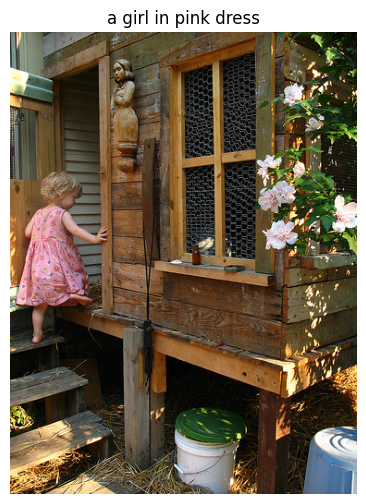

Cosine similarity between image and caption embeddings: 0.2149


'\nimport os\nimport torch\nfrom transformers import CLIPProcessor, CLIPModel\nfrom PIL import Image\nfrom tqdm import tqdm\n\n# === Configuration ===\nimages_directory = \'/kaggle/input/flickr8k/Images/\'\ncaptions_path    = \'/kaggle/input/flickr8k/captions.txt\'\noutput_dir       = \'/kaggle/embeddings\'\nos.makedirs(output_dir, exist_ok=True)\n\n# === Load CLIP model & processor ===\nmodel     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")\nprocessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")\nmodel.eval()\n\n# === Embedding helpers ===\n@torch.no_grad()\ndef get_image_embedding(image_path):\n    img    = Image.open(image_path).convert("RGB")\n    inputs = processor(images=img, return_tensors="pt")\n    feats  = model.get_image_features(**inputs)\n    return feats.squeeze()             # Tensor shape: (512,)\n\n@torch.no_grad()\ndef get_text_embedding(text):\n    inputs = processor(text=[text], return_tensors="pt")\n    feats  = model.get_text_feat

In [ ]:

from transformers import CLIPProcessor, CLIPModel

# 1. Load CLIP model & processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# 2. Specify your single image and single caption
image_path = '/content/sample_data/Flickr8k/Images/1000268201_693b08cb0e.jpg'
# caption    = "a little girl climbing into a wooden playhouse"
caption    = "a girl in pink dress"

# 3. Compute image embedding
image = Image.open(image_path).convert("RGB")
image_inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    image_features = model.get_image_features(**image_inputs).squeeze()  # Tensor of shape (512,)

# 4. Compute text embedding
text_inputs = processor(text=[caption], return_tensors="pt")
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs).squeeze()     # Tensor of shape (512,)

# 5. (Optional) Convert to NumPy arrays
image_embedding = image_features.float().cpu().numpy()
text_embedding  = text_features.float().cpu().numpy()

# 6. Inspect shapes / values
print("Image embedding shape:", image_embedding.shape)
print("Text embedding shape: ", text_embedding.shape)
import matplotlib.pyplot as plt
from PIL import Image

# after you’ve computed your embeddings…
print("Image embedding shape:", image_embedding.shape)
print("Text embedding shape: ", text_embedding.shape)


# Now load & show the image properly:
img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()

import numpy as np

# 1. Compute dot product
dot = np.dot(image_embedding, text_embedding)

# 2. Compute norms
norm_img  = np.linalg.norm(image_embedding)
norm_text = np.linalg.norm(text_embedding)

# 3. Cosine similarity
cos_sim = dot / (norm_img * norm_text)

print(f"Cosine similarity between image and caption embeddings: {cos_sim:.4f}")

In [ ]:
import os
import torch
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from transformers import CLIPProcessor, CLIPModel

# === PATHS ===
flickr_img_dir = '/content/sample_data/Flickr8k/Images'
caption_file = '/content/sample_data/Flickr8k/captions.txt'
output_dir = '/content/sample_data/Flickr8k/Flickr8k_embeddings'
os.makedirs(output_dir, exist_ok=True)

# === LOAD CLIP MODEL ===
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# === LOAD CAPTIONS SAFELY ===

def load_flickr8k_captions(caption_file):
    image_to_captions = defaultdict(list)

    with open(caption_file, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',', 1)  # Only split on the first comma
            if len(parts) != 2:
                continue
            image_file, caption = parts
            image_file = image_file.strip()
            caption = caption.strip()
            image_to_captions[image_file].append(caption)

    print(f"✅ Captions loaded for {len(image_to_captions)} images.")
    return image_to_captions

image_to_captions = load_flickr8k_captions(caption_file)

# === PROCESS IMAGES & CAPTIONS ===
for image_file in tqdm(sorted(image_to_captions.keys()), desc="Processing Flickr8k"):
    image_output_path = os.path.join(output_dir, f"{image_file.split('.')[0]}.pt")
    cap_paths = [os.path.join(output_dir, f"{image_file.split('.')[0]}_cap_{i+1}.pt") for i in range(5)]

    # Skip if image and all 5 caption embeddings already exist
    if os.path.exists(image_output_path) and all(os.path.exists(p) for p in cap_paths):
        continue

    image_path = os.path.join(flickr_img_dir, image_file)
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[!] Skipping unreadable image {image_file}: {e}")
        continue

    # --- Compute image embedding ---
    try:
        image_inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(**image_inputs).squeeze().float().cpu()
        torch.save(image_features, image_output_path)
    except Exception as e:
        print(f"[!] Error processing image {image_file}: {e}")
        continue

    # --- Compute caption embeddings ---
    captions = image_to_captions[image_file]
    for i, caption in enumerate(captions[:5]):  # Ensure at most 5
        cap_path = os.path.join(output_dir, f"{image_file.split('.')[0]}_cap_{i+1}.pt")
        if os.path.exists(cap_path):
            continue
        try:
            text_inputs = processor(text=[caption], return_tensors="pt")
            with torch.no_grad():
                text_features = model.get_text_features(**text_inputs).squeeze().float().cpu()
            torch.save(text_features, cap_path)
        except Exception as e:
            print(f"[!] Error processing caption {i+1} for {image_file}: {e}")
            continue

print("✅ All embeddings processed (or resumed).")


✅ Captions loaded for 8091 images.


Processing Flickr8k: 100%|██████████| 8091/8091 [1:30:57<00:00,  1.48it/s]

✅ All embeddings processed (or resumed).


In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# === CONFIGURATION ===
embedding_dir = '/content/sample_data/Flickr8k/embeddings_latest1'
top_k_values = [1, 3, 5]

# === LOAD EMBEDDINGS ===
def load_embeddings():
    image_embeddings = {}
    caption_embeddings = {}
    caption_to_image = defaultdict(list)

    for fname in os.listdir(embedding_dir):
        if not fname.endswith('.pt'):
            continue
        base = fname[:-3]
        path = os.path.join(embedding_dir, fname)

        if '_cap_' in base:
            caption_embeddings[base] = torch.load(path)
            image_id = base.split('_cap_')[0]
            caption_to_image[image_id].append(base)
        else:
            image_embeddings[base] = torch.load(path)

    return image_embeddings, caption_embeddings, caption_to_image

image_embeddings, caption_embeddings, caption_to_image = load_embeddings()

caption_keys = sorted(caption_embeddings.keys())
image_keys = sorted(image_embeddings.keys())

caption_matrix = torch.stack([caption_embeddings[k] for k in caption_keys]).numpy()
image_matrix = torch.stack([image_embeddings[k] for k in image_keys]).numpy()

# === METRIC HELPERS ===
def compute_top_k_metrics(similarities, ranked_keys, ground_truth_keys, top_k_values):
    result = {k: {"accuracy": 0, "precision": 0, "recall": 0} for k in top_k_values}
    for k in top_k_values:
        top_k = ranked_keys[:k]
        hits = len(set(top_k) & set(ground_truth_keys))
        result[k]["accuracy"] = 1 if hits > 0 else 0
        result[k]["precision"] = hits / k
        result[k]["recall"] = hits / len(ground_truth_keys)
    return result

def accumulate(results, current):
    for k in current:
        for metric in current[k]:
            results[k][metric] += current[k][metric]

def init_metrics():
    return {k: {"accuracy": 0, "precision": 0, "recall": 0} for k in top_k_values}

# === REPORT RESULTS ===
def report(title, metrics, total):
    print(f"\n📌 {title} Results on {total} Queries")
    for k in top_k_values:
        acc = metrics[k]["accuracy"] / total
        prec = metrics[k]["precision"] / total
        rec = metrics[k]["recall"] / total
        print(f"Top-{k}: Accuracy = {acc:.4f} | Precision = {prec:.4f} | Recall = {rec:.4f}")

# === IMAGE → TEXT ===
img2txt_metrics = init_metrics()
for img_id, img_vec in tqdm(image_embeddings.items(), desc="Image → Text"):
    img_np = img_vec.unsqueeze(0).numpy()
    sims = cosine_similarity(img_np, caption_matrix)[0]
    sorted_indices = np.argsort(sims)[::-1]
    ranked_keys = [caption_keys[i] for i in sorted_indices]
    true_keys = caption_to_image[img_id]
    metrics = compute_top_k_metrics(sims, ranked_keys, true_keys, top_k_values)
    accumulate(img2txt_metrics, metrics)

report("Image → Text", img2txt_metrics, len(image_embeddings))

# === TEXT → IMAGE ===
txt2img_metrics = init_metrics()
for cap_key, cap_vec in tqdm(caption_embeddings.items(), desc="Text → Image"):
    cap_np = cap_vec.unsqueeze(0).numpy()
    sims = cosine_similarity(cap_np, image_matrix)[0]
    sorted_indices = np.argsort(sims)[::-1]
    ranked_keys = [image_keys[i] for i in sorted_indices]
    true_key = cap_key.split('_cap_')[0]
    metrics = compute_top_k_metrics(sims, ranked_keys, [true_key], top_k_values)
    accumulate(txt2img_metrics, metrics)

report("Text → Image", txt2img_metrics, len(caption_embeddings))

# === TEXT → TEXT ===
txt2txt_metrics = init_metrics()
for i, (cap_key, cap_vec) in enumerate(tqdm(caption_embeddings.items(), desc="Text → Text")):
    cap_np = cap_vec.unsqueeze(0).numpy()
    sims = cosine_similarity(cap_np, caption_matrix)[0]
    sims[i] = -1e9  # avoid matching itself
    sorted_indices = np.argsort(sims)[::-1]
    ranked_keys = [caption_keys[j] for j in sorted_indices]
    true_keys = caption_to_image[cap_key.split('_cap_')[0]]
    true_keys = [k for k in true_keys if k != cap_key]
    metrics = compute_top_k_metrics(sims, ranked_keys, true_keys, top_k_values)
    accumulate(txt2txt_metrics, metrics)

report("Text → Text", txt2txt_metrics, len(caption_embeddings))


Image → Text: 100%|██████████| 8091/8091 [15:12<00:00,  8.87it/s]



📌 Image → Text Results on 8091 Queries
Top-1: Accuracy = 0.4690 | Precision = 0.4690 | Recall = 0.0938
Top-3: Accuracy = 0.6286 | Precision = 0.3756 | Recall = 0.2253
Top-5: Accuracy = 0.6999 | Precision = 0.3090 | Recall = 0.3090


Text → Image: 100%|██████████| 40455/40455 [13:07<00:00, 51.37it/s]



📌 Text → Image Results on 40455 Queries
Top-1: Accuracy = 0.2984 | Precision = 0.2984 | Recall = 0.2984
Top-3: Accuracy = 0.4560 | Precision = 0.1520 | Recall = 0.4560
Top-5: Accuracy = 0.5315 | Precision = 0.1063 | Recall = 0.5315


Text → Text: 100%|██████████| 40455/40455 [1:16:09<00:00,  8.85it/s]


📌 Text → Text Results on 40455 Queries
Top-1: Accuracy = 0.0003 | Precision = 0.0003 | Recall = 0.0001
Top-3: Accuracy = 0.4333 | Precision = 0.1978 | Recall = 0.1483
Top-5: Accuracy = 0.5205 | Precision = 0.1768 | Recall = 0.2210
